# Westcott $g_w$-factor tables and figures

This `Notebook` uses the methodology for the determination of Westcott $g_w$-factors outlined in the manuscript by Matters, et al., to produce the figures and tables in the manuscript.

In [1]:
import westcott_gfactors as gw
import numpy as np
from scipy.integrate import trapezoid
import matplotlib.pyplot as plt

# Constants
v_0 = 2200 #thermal-neutron velocity, m/s
eV = 1.602189e-19 #J
kB = 1.38066e-23 #Boltzmann's constant, J/K
m_n = 1.00866501 *1.660566e-27 #neutron mass, kg

# Neutron capture data ingested from ENDF 8.1 via FUDGE (reference 'n-capture-gnds.py')
capture_data_PATH = "/Users/davidmatters/westcott/n-capture-gnds/capture_data"

In [2]:
# Format isotopes in LaTeX for tables
def extract_element(isotope):
    letters = [char for char in isotope if char.isalpha()]
    return ''.join(letters)

def extract_mass(isotope):
    numbers = [char for char in isotope if char.isdigit()]
    return ''.join(numbers)

def format_isotope_latex(isotope):
    element = extract_element(isotope)
    mass_number = extract_mass(isotope)
    latex_format = "$^{" + mass_number + "}$" + element
    return latex_format

In [3]:
# Isotopes for table, from various references
isotopes_vanSlujis = ['S36', 'Ag107', 'Ag109', 'Rh103', 'Nb93', 'In113', 'In115',\
                      'Sb121', 'Cs133', 'Eu151', 'Eu153', 'Gd152', 'Sm152', 'Tb159',\
                      'Lu175', 'Lu176', 'Hf174', 'Hf178', 'Hf179', 'Ta181', 'Re185',\
                      'Re187', 'Ir191', 'Ir193', 'Os190', 'Hg196', 'Au197', 'Yb168',\
                      'Tm169', 'Dy164', 'W186', 'Hg204', 'Th232', 'U238']
isotopes_Holden = ['Rh103', 'Cd113', 'In115', 'Xe135', 'Pm148', 'Sm149', 'Sm151',\
                   'Eu151', 'Eu152', 'Eu153', 'Eu154', 'Eu155', 'Gd155', 'Gd157',\
                   'Dy164', 'Lu175', 'Lu176', 'Hf177', 'Ta182', 'Re185', 'Re187',\
                   'Au197', 'Pa231', 'Pa233', 'U235', 'U238']
isotopes_Molnar = ['Kr83', 'Rh103', 'Cd113', 'In113', 'In115', 'Te123', 'Sm149', \
                   'Eu151', 'Eu153', 'Gd155', 'Gd157', 'Dy164', 'Er167', 'Lu175', \
                   'Lu176', 'Hf174', 'Hf177', 'Re187', 'Ir193', 'Au197']
isotopes_Pritychenko = ['Cd113', 'Xe135', 'Sm149', 'Eu151', 'Lu176', 'Ta182', 'Pu239', 'Am243']
isotopes_IAEA = ['Si30', 'S36', 'Ar36', 'Ar38', 'Kr83', 'Sr87', 'Rh103', 'Pd105',\
                 'Ag109', 'Cd111', 'Cd113', 'In113', 'In115', 'Sb121', 'Te123',\
                 'Xe124', 'Ba132', 'Cs133', 'Ce138', 'Nd143', 'Sm149', 'Sm152',\
                 'Eu151', 'Eu153', 'Gd155', 'Gd157', 'Dy156', 'Dy158', 'Dy160',\
                 'Dy161', 'Dy162', 'Dy163', 'Dy164', 'Er167', 'Tm169', 'Yb168',\
                 'Hf174', 'Hf176', 'Lu175', 'Lu176', 'Hf177', 'Hf178', 'Hf179',\
                 'Hf180', 'Ta180', 'Ta181', 'W180', 'W182', 'Re185', 'Re187',\
                 'Os186', 'Os187', 'Ir191', 'Ir193', 'Au197', 'Hg196', 'Hg199',\
                 'Th232', 'U234', 'U235']
isotopes_IAEA_resonance_table = ['Si30', 'S36', 'Ar36', 'Ar38', 'Kr83', 'Sr87',\
                                 'Rh103', 'Pd105','Ag107', 'Ag109', 'Nb93',\
                                 'Cd111', 'Cd113', 'In113', 'In115','Sb121',\
                                 'Te123', 'Xe124', 'Ba132', 'Cs133', 'Ce138',\
                                 'Nd143','Pm148', 'Sm149', 'Sm151', 'Sm152',\
                                 'Eu151', 'Eu152', 'Eu153','Eu154', 'Eu155',\
                                 'Gd152', 'Gd155', 'Gd157', 'Tb159', 'Dy156',\
                                 'Dy158', 'Dy160', 'Dy161', 'Dy162', 'Dy163',\
                                 'Dy164', 'Er167','Yb168', 'Tm169', 'Lu175',\
                                 'Lu176', 'Hf174', 'Hf176', 'Hf177','Hf178',\
                                 'Hf179', 'Hf180', 'Ta180', 'Ta181', 'Ta182',\
                                 'W180','W182', 'Re185', 'Re187', 'Os186',\
                                 'Os187', 'Ir191', 'Ir192','Ir193', 'Os190',\
                                 'Hg196', 'Hg199', 'Au197', 'Hg204','Th229',\
                                 'Th232', 'U234', 'U235', 'U238', 'Pa231',\
                                 'Pa233', 'Np237','Pu239', 'Pu240','Pu241',\
                                 'Am241', 'Am242', 'Cf249', 'Cf252','Bk249']
# Combination of all the above
isotopes_all = ['Si30', 'S36', 'Ar36', 'Ar38', 'Kr83', 'Sr87', 'Rh103',\
                     'Pd105','Ag107', 'Ag109', 'Nb93', 'Cd111', 'Cd113',\
                     'In113', 'In115','Sb121', 'Te123', 'Xe124', 'Xe135', 'Ba132',\
                     'Cs133', 'Ce138', 'Nd143','Pm148', 'Sm149', 'Sm151',\
                     'Sm152', 'Eu151', 'Eu152', 'Eu153','Eu154', 'Eu155',\
                     'Gd152', 'Gd155', 'Gd157', 'Tb159', 'Dy156','Dy158',\
                     'Dy160', 'Dy161', 'Dy162', 'Dy163', 'Dy164', 'Er167',\
                     'Yb168', 'Tm169', 'Lu175', 'Lu176', 'Hf174', 'Hf176',\
                     'Hf177','Hf178', 'Hf179', 'Hf180', 'Ta180', 'Ta181',\
                     'Ta182', 'W180','W182', 'Re185', 'Re187', 'Os186',\
                     'Os187', 'Ir191', 'Ir192','Ir193', 'Os190', 'Hg196',\
                     'Hg199', 'Au197', 'Hg204', 'Th229','Th232', 'U234',\
                     'U235', 'Pa231', 'Pa233', 'Np237','Pu239', 'Pu240',\
                     'Pu241', 'Am241', 'Am242', 'Am243', 'Cf249', 'Cf252','Bk249']

# Isotopes used for comparing g-factor calculation methods
isotopes_comparison = ['Kr83', 'In115', 'Sm149', 'Eu151', 'Gd157', 'Lu176', 'Au197']

# Temperatures used in IAEA tables
temperatures_IAEA = [20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220, 240, 260,\
                280, 293, 300, 320, 340, 360, 380, 400, 420, 440, 460, 480,\
                500, 520, 540, 560, 580, 600]  #K

# Temperatures used for comparing g-factor calculation methods
temperatures_comparison = [100, 200, 293, 400, 500, 600]  #K

In [4]:
# Lowest-energy resonance parameters for select nuclei from ENDF/B-VIII.1 and Mughabghab's Atlas, to demonstrate irregularity method
class Reference_resonance:
    def __init__(self, isotope, E_resonance, Gamma, data_source):
        self.isotope = isotope
        self.energy = E_resonance
        self.width = Gamma
        self.library = data_source

resonances_ENDF = [
    Reference_resonance('Kr83', -9.81, 3.8400000e-01, 'ENDF'),
        Reference_resonance('In115', 1.457, 75.0/1000, 'ENDF'),
    Reference_resonance('Sm149', 0.0973, 63.4/1000, 'ENDF'),
    Reference_resonance('Eu151', -0.0609, 0.1052768, 'ENDF'),
    Reference_resonance('Gd157', 0.0314, 0.1072 + 4.74E-04, 'ENDF'),
    Reference_resonance('Lu176', 0.1413, 62.4/1000, 'ENDF'),
    Reference_resonance('Au197', 4.8997, 136.4/1000, 'ENDF')
    ]

resonances_Atlas = [
    Reference_resonance('Kr83', -9.81, 252/1000, 'Atlas'),
        Reference_resonance('In115', 1.457, 72/1000, 'Atlas'),
    Reference_resonance('Sm149', 0.0973, 62.9/1000, 'Atlas'),
    Reference_resonance('Eu151', -0.00362, 95.8/1000, 'Atlas'),
    Reference_resonance('Gd157', 0.0314, 107/1000, 'Atlas'),
    Reference_resonance('Lu176', 0.1379, 65.0/1000, 'Atlas'),
    Reference_resonance('Au197', 4.890, 124/1000, 'Atlas')
    ]

resonances_PGAA = [
    Reference_resonance('Kr83', -3.9, 245/1000, 'PGAA_Handbook'),
    Reference_resonance('In115', 1.457, 75.04/100, 'PGAA_Handbook'),
    Reference_resonance('Sm149', 0.0973, 61/1000, 'PGAA_Handbook'),
    Reference_resonance('Eu151', 0.00361, 95.8/1000, 'PGAA_Handbook'),
    Reference_resonance('Gd157', 0.0314, 106/1000, 'PGAA_Handbook'),
    Reference_resonance('Lu176', 0.141, 62.4/1000, 'PGAA_Handbook'),
    Reference_resonance('Au197', 4.906, 137.7/1000, 'PGAA_Handbook')
    ]

def get_resonance_parameters(isotope, library='ENDF'):
    for resonance in (resonances_ENDF + resonances_Atlas + resonances_PGAA):
        if resonance.isotope == isotope and resonance.library == library:
            return(resonance.energy, resonance.width)

In [5]:
# Tabulated g-factor data from various references
class Reference_gfactors:
    def __init__(self, isotope, temperatures, gfactors, reference):
        self.isotope = isotope
        self.temperatures = temperatures
        self.gfactors = gfactors
        self.reference = reference

Reference_gfactors_PGAA = [
    Reference_gfactors('Kr83', [0, 30, 70, 100, 150, 200, 293, 320], [1.013, 1.011, 1.008, 1.006, 1.003, 1.000, 0.994, 0.992], 'PGAA'),
    Reference_gfactors('In115', [0, 30, 70, 100, 150, 200, 293, 320], [0.966, 0.971, 0.978, 0.983, 0.992, 1.002, 1.019, 1.025], 'PGAA'),
    Reference_gfactors('Sm149', [0, 30, 70, 100, 150, 200, 293, 320], [0.589, 0.638, 0.718, 0.799, 0.992, 1.245, 1.738, 1.861], 'PGAA'),
    Reference_gfactors('Eu151', [0, 30, 70, 100, 150, 200, 293, 320], [1.198, 1.200, 1.168, 1.128, 1.051, 0.974, 0.843, 0.810], 'PGAA'),
    Reference_gfactors('Gd157', [0, 30, 70, 100, 150, 200, 293, 320], [0.750, 0.800, 0.853, 0.881, 0.901, 0.896, 0.851, 0.834], 'PGAA'),
    Reference_gfactors('Lu176', [0, 30, 70, 100, 150, 200, 293, 320], [0.990, 0.992, 0.994, 0.995, 0.997, 1.000, 1.003, 1.004], 'PGAA'),
    Reference_gfactors('Au197', [0, 30, 70, 100, 150, 200, 293, 320], [0.990, 0.991, 0.993, 0.995, 0.998, 1.000, 1.005, 1.007], 'PGAA')
    ]

Reference_gfactors_IAEA = [
    Reference_gfactors('Kr83', temperatures_IAEA, [1.011, 1.010, 1.009, 1.008, 1.006, 1.005, 1.004, 1.003,\
                                   1.001, 1.000, 0.999, 0.998, 0.996, 0.996, 0.995, 0.994,\
                                   0.993, 0.992, 0.991, 0.989, 0.988, 0.987, 0.986, 0.985,\
                                   0.984, 0.982, 0.981, 0.980, 0.979, 0.978, 0.976], 'IAEA'),
    Reference_gfactors('In115', temperatures_IAEA, [0.969, 0.973, 0.976, 0.979, 0.984, 0.987, 0.990, 0.994, \
                                                    0.998, 1.002, 1.005, 1.009, 1.012, 1.016, 1.019, 1.021, \
                                                    1.025, 1.028, 1.033, 1.037, 1.041, 1.045, 1.049, 1.053, \
                                                    1.057, 1.062, 1.066, 1.071, 1.075, 1.080, 1.084], 'IAEA'),
    Reference_gfactors('Sm149', temperatures_IAEA, [0.622, 0.656, 0.696, 0.743, 0.800, 0.867, 0.947, 1.036,\
                                                    1.135, 1.239, 1.345, 1.452, 1.556, 1.656, 1.718, 1.749,\
                                                    1.838, 1.918, 1.992, 2.058, 2.119, 2.172, 2.219, 2.260,\
                                                    2.294, 2.325, 2.349, 2.370, 2.387, 2.400, 2.409], 'IAEA'),
    Reference_gfactors('Eu151', temperatures_IAEA, [1.273, 1.251, 1.223, 1.193, 1.161, 1.129, 1.097, 1.067,\
                                    1.038, 1.010, 0.984, 0.959, 0.936, 0.914, 0.900, 0.893,\
                                    0.874, 0.856, 0.840, 0.825, 0.811, 0.799, 0.787, 0.777,\
                                    0.769, 0.761, 0.755, 0.750, 0.746, 0.744, 0.743], 'IAEA'),
    Reference_gfactors('Gd157', temperatures_IAEA, [0.794, 0.824, 0.850, 0.871, 0.887, 0.898, 0.904, 0.905,\
                                    0.904, 0.899, 0.891, 0.882, 0.872, 0.860, 0.852, 0.847,\
                                    0.834, 0.821, 0.807, 0.793, 0.779, 0.765, 0.751, 0.737,\
                                    0.723, 0.710, 0.697, 0.684, 0.671, 0.659, 0.647], 'IAEA'),
    Reference_gfactors('Lu176', temperatures_IAEA, [0.716, 0.744, 0.774, 0.808, 0.847, 0.892,\
                                                    0.945, 1.010, 1.086, 1.176, 1.280, 1.395,\
                                                    1.523, 1.658, 1.752, 1.802, 1.949, 2.099,\
                                                    2.250, 2.399, 2.545, 2.688, 2.826, 2.959,\
                                                    3.085, 3.205, 3.318, 3.424, 3.524, 3.618, 3.704], 'IAEA'),
    Reference_gfactors('Au197', temperatures_IAEA, [0.991, 0.992, 0.993, 0.994, 0.995, 0.996, 0.997,\
                                                    0.998, 0.999, 1.000, 1.001, 1.003, 1.003, 1.005,\
                                                    1.005, 1.005, 1.006, 1.007, 1.008, 1.009, 1.010,\
                                                    1.011, 1.012, 1.013, 1.014, 1.015, 1.016, 1.018,\
                                                    1.018, 1.020, 1.021], 'IAEA')
    ]

def get_reference_gfactor(isotope, T, source):
    for reference_gfactors in (Reference_gfactors_PGAA + Reference_gfactors_IAEA):
        if reference_gfactors.reference == source:
            if reference_gfactors.isotope == isotope:
                temps = reference_gfactors.temperatures
                gs = reference_gfactors.gfactors
                try:
                    i = temps.index(T)
                    g = gs[i]
                except:
                    g = ''
    return g

# Figure 1: BRR, FRM-II, and Maxwellian spectra

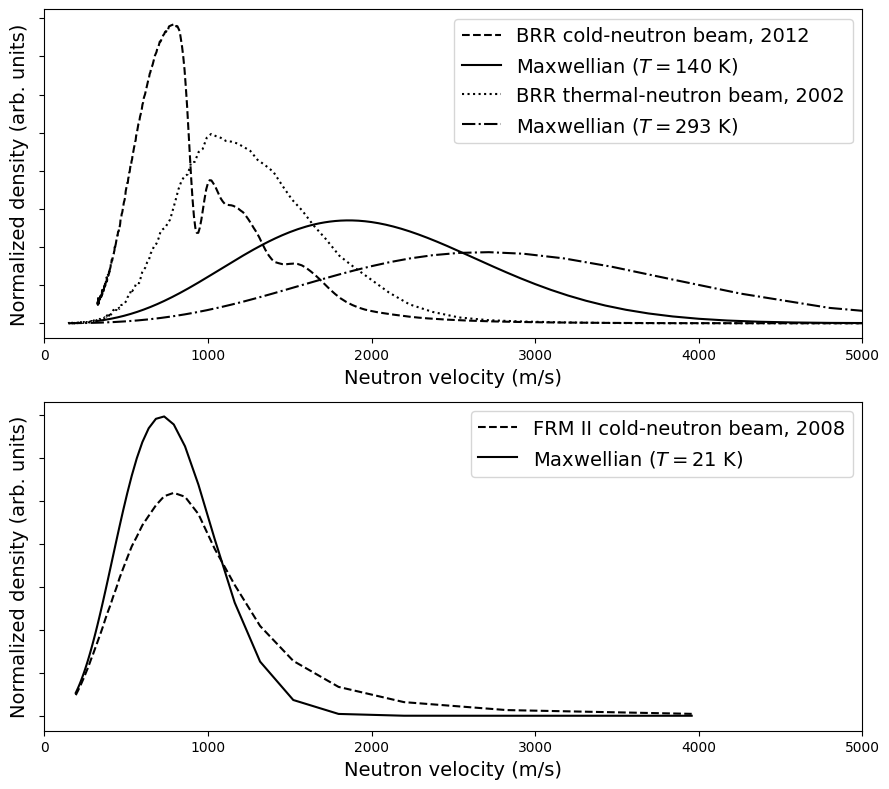

In [6]:
# Define and plot neutron velocity distributions from energy spectra
def p(vn, phi, T=293):
    p_array = []
    for i in range(len(vn)):
        vt = np.sqrt(2 * kB * T / m_n)
        p_array.append(2 * vt * phi[i] / (np.sqrt(np.pi) * vn[i]))
    N = trapezoid(np.array(p_array), vn)  # Normalization factor, to ensure integral of p(T,v) integrates to 1 (Molnar p. 12)
    return np.array(p_array)/N

# Import BRR and FRM II neutron spectra
En_BRR_thermal, dndE_BRR_thermal = gw.import_spectrum('/Users/davidmatters/westcott/spectra/csv/bnc_thermal_spectrum_2002.csv')
En_BRR_cold, dndE_BRR_cold = gw.import_spectrum('/Users/davidmatters/westcott/spectra/csv/bnc_cold_spectrum_2012.csv')
En_FRM_cold, dndE_FRM_cold = gw.import_spectrum('/Users/davidmatters/westcott/spectra/csv/frm-ii_cold_spectrum_2008.csv')

# Prepare BRR distributions to plot against Maxwellian
p_BRR_cold = p(gw.vel(En_BRR_cold), dndE_BRR_cold)
p_BRR_thermal = p(gw.vel(En_BRR_thermal), dndE_BRR_thermal)
p_FRM_cold = p(gw.vel(En_FRM_cold), dndE_FRM_cold)

p_Maxwellian_21 = gw.phi_Maxwellian(21, gw.vel(En_FRM_cold))
p_Maxwellian_140 = gw.phi_Maxwellian(140, gw.vel(En_BRR_cold))
p_Maxwellian_293 = gw.phi_Maxwellian(293, gw.vel(En_BRR_thermal))

f = plt.figure(figsize=(9,8))
ax = f.add_subplot(211)
ax2 = f.add_subplot(212)

# BRR and Maxwellian spectra
plt.subplot(2,1,1)
plt.plot(gw.vel(En_BRR_cold), p_BRR_cold, color='k', linestyle='dashed')
plt.plot(gw.vel(En_BRR_cold), p_Maxwellian_140, color='k', linestyle='solid')
plt.plot(gw.vel(En_BRR_thermal), p_BRR_thermal, color='k', linestyle='dotted')
plt.plot(gw.vel(En_BRR_thermal), p_Maxwellian_293, color='k', linestyle='dashdot')

ax = plt.gca()
ax.set_xlim([0,5000])
plt.xlabel(r"Neutron velocity (m/s)", size = 14)
plt.ylabel(r"Normalized density (arb. units)", size = 14)
ax.axes.yaxis.set_ticklabels([])
plt.legend([r"BRR cold-neutron beam, 2012", r"Maxwellian ($T=140$ K)", r"BRR thermal-neutron beam, 2002", r"Maxwellian ($T=293$ K)"], loc='best', prop={'size':14})

# FRM II and Maxwellian spectra
plt.subplot(2,1,2)
plt.plot(gw.vel(En_FRM_cold), p_FRM_cold, color='k', linestyle='dashed')
plt.plot(gw.vel(En_FRM_cold), p_Maxwellian_21, color='k', linestyle='solid')

ax2 = plt.gca()
ax2.set_xlim([0,5000])
plt.xlabel(r"Neutron velocity (m/s)", size = 14)
plt.ylabel(r"Normalized density (arb. units)", size = 14)
ax2.axes.yaxis.set_ticklabels([])
plt.legend([r"FRM II cold-neutron beam, 2008", r"Maxwellian ($T=21$ K)"], loc='best', prop={'size':14})

plt.tight_layout()
plt.savefig('spectra/spectra_BRR_FRM-II.pdf', bbox_inches='tight')

# Table 2: $g$-factor comparison between irregularity function method and references

In [7]:
# Reproduce the g-factor tables in the PGAA Handbook, using the irregularity function method
print("\\begin{table}[pos=h]")
print("\\centering{}\\caption{Westcott $g$ factors calculated using the irregularity function method with parameters from ENDF/B-VIII.1 \\citep{Brown18,Nobre24} and the \\textit{Atlas of Neutron Resonances} \\citep{Mughabghab18} parameters for select non-$1/v$ nuclei using Maxwellian neutron energy distributions with varying average temperatures $T$.  Included for comparison are Westcott $g$ factor values from the IAEA \\textit{Database of Prompt Gamma Rays from Slow Neutron Capture for Elemental Analysis} (\\citep{IAEA}) and the PGAA Handbook (\\citep{Molnar}). \\protect\\label{Table:References_comparison}}")
print("\\begin{tabular}{|p{1cm}||p{1.5cm}|p{2cm}|p{2cm}|p{2cm}|p{2cm}|}")
print("\\hline")
print("Isotope & $T$ (K) & $g_w$(ENDF) & $g_w$(Atlas) & $g_w$(IAEA) & $g_w$(PGAA) \\\\")
print("\\hline")
print("\\hline")
for isotope in isotopes_comparison:
    for T in temperatures_comparison:
        if T == 100:
            row = f"{format_isotope_latex(isotope)}"
        else: 
            row = " "
        row += f" & {T}"
        Er, Gamma = get_resonance_parameters(isotope, library='ENDF')
        gw_irreg_ENDF = gw.gw_irregularity(Er, Gamma, np.linspace(1,100000,100000), gw.phi_Maxwellian(T,np.linspace(1,100000,100000)), T)
        row += f" & {gw_irreg_ENDF:.3f}"
        Er, Gamma = get_resonance_parameters(isotope, library='Atlas')
        gw_irreg_Atlas = gw.gw_irregularity(Er, Gamma, np.linspace(1,100000,100000), gw.phi_Maxwellian(T,np.linspace(1,100000,100000)), T)
        row += f" & {gw_irreg_Atlas:.3f}"
        row += f" & {get_reference_gfactor(isotope, T, 'IAEA'):.3f}"
        if get_reference_gfactor(isotope, T, 'PGAA') != '':
            if isotope == 'Eu151':
                row += f" & {get_reference_gfactor(isotope, T, 'PGAA'):.3f}" + "$^{a}$"
            elif isotope == 'Lu176':
                row += f" & {get_reference_gfactor(isotope, T, 'PGAA'):.3f}" + "$^{b}$"
            else:
                row += f" & {get_reference_gfactor(isotope, T, 'PGAA'):.3f}"
        else:
            row += " &  "  
        print(row + "\\\\")
    print("\\hline")
print("\\end{tabular}")
print("\\\\$^{a}$Values could only be reproduced using $E_r = +0.00361$ eV; see note in Table \\ref{Table:Resonance_parameters}\\\\")
print("$^{b}$Values could only be reproduced using $E_r = 4.36$ eV and $\\Gamma = 68.4$ meV; see note in Table \\ref{Table:Resonance_parameters}")
print("\\end{table}")

\begin{table}[pos=h]
\centering{}\caption{Westcott $g$ factors calculated using the irregularity function method with parameters from ENDF/B-VIII.1 \citep{Brown18,Nobre24} and the \textit{Atlas of Neutron Resonances} \citep{Mughabghab18} parameters for select non-$1/v$ nuclei using Maxwellian neutron energy distributions with varying average temperatures $T$.  Included for comparison are Westcott $g$ factor values from the IAEA \textit{Database of Prompt Gamma Rays from Slow Neutron Capture for Elemental Analysis} (\citep{IAEA}) and the PGAA Handbook (\citep{Molnar}). \protect\label{Table:References_comparison}}
\begin{tabular}{|p{1cm}||p{1.5cm}|p{2cm}|p{2cm}|p{2cm}|p{2cm}|}
\hline
Isotope & $T$ (K) & $g_w$(ENDF) & $g_w$(Atlas) & $g_w$(IAEA) & $g_w$(PGAA) \\
\hline
\hline
$^{83}$Kr & 100 & 1.003 & 1.003 & 1.006 & 1.006\\
  & 200 & 1.000 & 1.000 & 1.000 & 1.000\\
  & 293 & 0.997 & 0.997 & 0.995 & 0.994\\
  & 400 & 0.995 & 0.995 & 0.988 &  \\
  & 500 & 0.992 & 0.992 & 0.982 &  \\
  & 600

# Table 3: $g$-factor comparison between irregularity function & cross-section integration methods

In [8]:
# Compare g-factors calculated using the irregularity method outlined in Molnar text with those from the cross-section integration method

print("\\begin{table}[pos=h]")
print("\\centering{}\\caption{Westcott $g$ factors calculated for select non-$1/v$ nuclei using Maxwellian neutron velocity distributions with average temperatures $T$ between 100-600~K.  For the irregularity function method, resonance parameters are from ENDF/B-VIII.1, and for the cross-section integration method, cross sections are taken from GNDS-formatted data in ENDF/B-VIII.1.  Percentage differences between the $g_w$ values obtained using the two methods are included to facilitate comparison. \\protect\\label{Table:Irregularity_comparison}}")
print("\\begin{tabular}{|p{1cm}||p{1cm}|p{3.5cm}|p{4cm}|p{2cm}|}")
print("\\hline")
print("Isotope & $T$ (K) & $g_w$(Irregularity Function) & $g_w$(Cross Section Integration) & \\% Difference \\\\")
print("\\hline")
print("\\hline")
for isotope in isotopes_comparison:
    for T in temperatures_comparison:
        if T == 100:
            row = f"{format_isotope_latex(isotope)}"
        else: 
            row = " "
        row += f" & {T}"
        Er, Gamma = get_resonance_parameters(isotope, library='ENDF')
        gw_irreg_ENDF = gw.gw_irregularity(Er, Gamma, np.linspace(1,100000,100000), gw.phi_Maxwellian(T,np.linspace(1,100000,100000)), T)
        row += f" & {gw_irreg_ENDF:.3f}"
        sigma_x, sigma_y = gw.sigma_ENDF(capture_data_PATH, isotope)
        gw_csi_ENDF = gw.gw_Maxwellian(T, sigma_x, sigma_y)
        row += f" & {gw_csi_ENDF:.3f}"
        delta = (gw_csi_ENDF - gw_irreg_ENDF)/gw_csi_ENDF * 100
        row += f" & {delta:.1f}"
        print(row + "\\\\")
    print("\\hline")
print("\\end{tabular}")
print("\\end{table}")

\begin{table}[pos=h]
\centering{}\caption{Westcott $g$ factors calculated for select non-$1/v$ nuclei using Maxwellian neutron velocity distributions with average temperatures $T$ between 100-600~K.  For the irregularity function method, resonance parameters are from ENDF/B-VIII.1, and for the cross-section integration method, cross sections are taken from GNDS-formatted data in ENDF/B-VIII.1.  Percentage differences between the $g_w$ values obtained using the two methods are included to facilitate comparison. \protect\label{Table:Irregularity_comparison}}
\begin{tabular}{|p{1cm}||p{1cm}|p{3.5cm}|p{4cm}|p{2cm}|}
\hline
Isotope & $T$ (K) & $g_w$(Irregularity Function) & $g_w$(Cross Section Integration) & \% Difference \\
\hline
\hline
$^{83}$Kr & 100 & 1.003 & 1.002 & -0.1\\
  & 200 & 1.000 & 0.998 & -0.2\\
  & 293 & 0.997 & 0.995 & -0.2\\
  & 400 & 0.995 & 0.992 & -0.3\\
  & 500 & 0.992 & 0.988 & -0.4\\
  & 600 & 0.990 & 0.985 & -0.5\\
\hline
$^{115}$In & 100 & 0.983 & 0.989 & 0.6\\
  

# Table 4: $g$ factor comparison between Python script and DeCE for Maxwellian distributions

In [9]:
# Compare g-factors calculated using the cross-section integration method with Python vs. DeCE

# Import data from DeCE output files
def import_dece_data(dece_output_filename):
    dece_gfactors = {}
    with open(dece_output_filename) as dece_data:
        next(dece_data)
        for line in dece_data:
            line = line.strip()
            T, g_w = line.split()
            dece_gfactors[float(T)] = float(g_w)
    return dece_gfactors

Kr83_dece_gfactors = import_dece_data('/Users/davidmatters/westcott/dece/dece_output_Kr83.dat')
In115_dece_gfactors = import_dece_data('/Users/davidmatters/westcott/dece/dece_output_In115.dat')
Sm149_dece_gfactors = import_dece_data('/Users/davidmatters/westcott/dece/dece_output_Sm149.dat')
Eu151_dece_gfactors = import_dece_data('/Users/davidmatters/westcott/dece/dece_output_Eu151.dat')
Gd157_dece_gfactors = import_dece_data('/Users/davidmatters/westcott/dece/dece_output_Gd157.dat')
Lu176_dece_gfactors = import_dece_data('/Users/davidmatters/westcott/dece/dece_output_Lu176.dat')
Au197_dece_gfactors = import_dece_data('/Users/davidmatters/westcott/dece/dece_output_Au197.dat')

# Build LaTeX table
print("\\begin{table}[pos=h]")
print("\\centering{}\\caption{Westcott $g$ factors calculated for select non-$1/v$ nuclei using Maxwellian neutron velocity distributions with various average temperatures $T$.  Cross sections are taken from ENDF/B-VIII.1, in the GNDS format for use with the Python scripts described in the text, and in ENDF-6 format for use with DeCE.  Percentage differences between the $g_w$ values obtained using the two methods are included to facilitate comparison. \\protect\\label{Table:DeCE_comparison}}")
print("\\begin{tabular}{|p{1cm}||p{1cm}|p{2cm}|p{2cm}|p{2cm}|}")
print("\\hline")
print("Isotope & $T$ (K) & $g_w$(Python) & $g_w$(DeCE) & \\% Difference \\\\")
print("\\hline")
print("\\hline")
for isotope in isotopes_comparison:
    for T in temperatures_comparison:
        row = ''
        if T == 100:
            row = f"{format_isotope_latex(isotope)}"
            row += f" & {T}"
            sigma_x, sigma_y = gw.sigma_ENDF(capture_data_PATH, isotope)
            gw_csi_ENDF = gw.gw_Maxwellian(T, sigma_x, sigma_y)
            row += f" & {gw_csi_ENDF:.3f}"
            if isotope == 'Kr83':
                gw_dece = Kr83_dece_gfactors[T]
            elif isotope == 'In115':
                gw_dece = In115_dece_gfactors[T]
            elif isotope == 'Sm149':
                gw_dece = Sm149_dece_gfactors[T]
            elif isotope == 'Eu151':
                gw_dece = Eu151_dece_gfactors[T]
            elif isotope == 'Gd157':
                gw_dece = Gd157_dece_gfactors[T]
            elif isotope == 'Lu176':
                gw_dece = Lu176_dece_gfactors[T]
            elif isotope == 'Au197':
                gw_dece = Au197_dece_gfactors[T]
            else:
                pass
            row += f" & {gw_dece:.3f}"
        else: 
            row = " "
            row += f" & {T}"
            sigma_x, sigma_y = gw.sigma_ENDF(capture_data_PATH, isotope)
            gw_csi_ENDF = gw.gw_Maxwellian(T, sigma_x, sigma_y)
            row += f" & {gw_csi_ENDF:.3f}"
            if isotope == 'Kr83':
                gw_dece = Kr83_dece_gfactors[T]
            elif isotope == 'In115':
                gw_dece = In115_dece_gfactors[T]
            elif isotope == 'Sm149':
                gw_dece = Sm149_dece_gfactors[T]
            elif isotope == 'Eu151':
                gw_dece = Eu151_dece_gfactors[T]
            elif isotope == 'Gd157':
                gw_dece = Gd157_dece_gfactors[T]
            elif isotope == 'Lu176':
                gw_dece = Lu176_dece_gfactors[T]
            elif isotope == 'Au197':
                gw_dece = Au197_dece_gfactors[T]
            else:
                pass
            row += f" & {gw_dece:.3f}"
        delta = (gw_csi_ENDF - gw_dece)/gw_csi_ENDF * 100
        row += f" & {delta:.1f}"
        print(row + "\\\\")
    print("\\hline")
print("\\end{tabular}")
print("\\end{table}")

\begin{table}[pos=h]
\centering{}\caption{Westcott $g$ factors calculated for select non-$1/v$ nuclei using Maxwellian neutron velocity distributions with various average temperatures $T$.  Cross sections are taken from ENDF/B-VIII.1, in the GNDS format for use with the Python scripts described in the text, and in ENDF-6 format for use with DeCE.  Percentage differences between the $g_w$ values obtained using the two methods are included to facilitate comparison. \protect\label{Table:DeCE_comparison}}
\begin{tabular}{|p{1cm}||p{1cm}|p{2cm}|p{2cm}|p{2cm}|}
\hline
Isotope & $T$ (K) & $g_w$(Python) & $g_w$(DeCE) & \% Difference \\
\hline
\hline
$^{83}$Kr & 100 & 1.002 & 1.003 & -0.1\\
  & 200 & 0.998 & 0.999 & -0.1\\
  & 293 & 0.995 & 0.996 & -0.1\\
  & 400 & 0.992 & 0.993 & -0.1\\
  & 500 & 0.988 & 0.990 & -0.1\\
  & 600 & 0.985 & 0.986 & -0.1\\
\hline
$^{115}$In & 100 & 0.989 & 0.990 & -0.1\\
  & 200 & 1.014 & 1.015 & -0.1\\
  & 293 & 1.038 & 1.039 & -0.1\\
  & 400 & 1.067 & 1.068 & -0.

# Table 5: $g$-factor data for all isotopes with Maxwellian spectra

In [10]:
# Generate tables of Maxwellian data, formatting in LaTeX
def print_latex_table(headers, temperatures):
    # Start the LaTeX table
    print("\\renewcommand{\\arraystretch}{1.5}")
    print("\\begin{tabular}{|c||c|" + "c|" * (len(headers) - 1) + "}")
    print("\\hline")
    headers_latex = []
    for i in range(len(headers)):
        headers_latex.append(format_isotope_latex(headers[i])) 
    header_row = " & ".join(headers_latex)
    print("$T~(K)$ & " + header_row + "\\\\")
    print("\\hline")
    print("\\hline")

    # Print the table rows
    for T in temperatures_IAEA:
        row = f"{T}"
        for isotope in headers:
            sigma_x, sigma_y = gw.sigma_ENDF(capture_data_PATH, isotope)
            g = gw.gw_Maxwellian(T, sigma_x, sigma_y)
            row += f" & {g:.3f}"
        print(row + "\\\\")
        print("\\hline")

def create_tables(isotopes_list, num_tables=1):
    # Define the headers and data
    headers = isotopes_list

    # Split the headers into parts
    headers_per_table = len(headers) // num_tables
    remaining_headers = len(headers) % num_tables

    start_index = 0
    for i in range(num_tables):
        end_index = start_index + headers_per_table + (1 if i < remaining_headers else 0)
        table_headers = headers[start_index:end_index]
        print_latex_table(table_headers, temperatures_IAEA)
        if i < num_tables-1:
            print("\\end{tabular}")
            print("\\end{table}")
            print("\\clearpage")
            print("\\begin{table}[pos=h]")
        else:
            print("\\end{tabular}")
            print("\\end{table}")
        start_index = end_index

# Generate the LaTeX table
print("\\begin{table}[pos=h]")
print("\\centering{}\\caption{Maxwellian-distribution Westcott $g$ factors at various temperatures $T$ for non-$1/v$ nuclei listed in References \\citep{IAEA, Molnar, vanSluijs15, Holden99, Pritychenko25}, calculated using cross sections from ENDF/B-VIII.1 \\citep{Brown18,Nobre24}. \\protect\\label{Table:Maxwellian_g-factors}}")
create_tables(isotopes_all, 7)

\begin{table}[pos=h]
\centering{}\caption{Maxwellian-distribution Westcott $g$ factors at various temperatures $T$ for non-$1/v$ nuclei listed in References \citep{IAEA, Molnar, vanSluijs15, Holden99, Pritychenko25}, calculated using cross sections from ENDF/B-VIII.1 \citep{Brown18,Nobre24}. \protect\label{Table:Maxwellian_g-factors}}
\renewcommand{\arraystretch}{1.5}
\begin{tabular}{|c||c|c|c|c|c|c|c|c|c|c|c|c|c|}
\hline
$T~(K)$ & $^{30}$Si & $^{36}$S & $^{36}$Ar & $^{38}$Ar & $^{83}$Kr & $^{87}$Sr & $^{103}$Rh & $^{105}$Pd & $^{107}$Ag & $^{109}$Ag & $^{93}$Nb & $^{111}$Cd & $^{113}$Cd\\
\hline
\hline
20 & 1.000 & 0.803 & 1.159 & 1.304 & 1.004 & 0.990 & 0.965 & 1.002 & 1.003 & 0.992 & 1.000 & 1.001 & 0.789\\
\hline
40 & 1.000 & 0.860 & 1.101 & 1.256 & 1.004 & 0.992 & 0.971 & 1.001 & 1.002 & 0.993 & 1.000 & 1.001 & 0.819\\
\hline
60 & 1.000 & 0.895 & 1.064 & 1.181 & 1.003 & 0.993 & 0.976 & 1.001 & 1.002 & 0.995 & 1.000 & 1.001 & 0.852\\
\hline
80 & 1.000 & 0.921 & 1.044 & 1.131 & 1.00

# Table 6: $g$-factor comparison between Maxwellian and BRR/FRM II spectra

In [11]:
# Compare BNC (2002 & 2012) and Maxwellian values for several non-1/v nuclei

print("\\begin{table}[pos=h]")
print("\\centering{}\\caption{Comparison of Westcott $g$ factors for select non-$1/v$ nuclei using Maxwellian neutron velocity distributions, BRR cold- and thermal-neutron spectra, and the FRM-II reactor cold-neutron spectrum. \\protect\\label{Table:Reactor_comparison}}")
print("\\renewcommand{\\arraystretch}{1.5}")
print("\\begin{tabular}{|p{1cm}||p{1.5cm}|p{2cm}||p{1.5cm}|p{2.5cm}||p{1.5cm}|p{2.5cm}|}")
print("\\hline")
print("Isotope & $g_w$(140~K) & $g_w$, BRR cold & $g_w$(293~K) & $g_w$, BRR thermal & $g_w$(21~K) & $g_w$, FRM~II cold \\\\")
print("\\hline")
print("\\hline")
for isotope in isotopes_comparison:
    sigma_x, sigma_y = gw.sigma_ENDF(capture_data_PATH, isotope)
    row = f"{format_isotope_latex(isotope)}"
    value = gw.gw_Maxwellian(140, sigma_x, sigma_y)
    row += f" & {value:.3f}"
    value = gw.gw_arbitrary(En_BRR_cold, dndE_BRR_cold, sigma_x, sigma_y)
    row += f" & {value:.3f}"
    value = gw.gw_Maxwellian(293, sigma_x, sigma_y)
    row += f" & {value:.3f}"
    value = gw.gw_arbitrary(En_BRR_thermal, dndE_BRR_thermal, sigma_x, sigma_y)
    row += f" & {value:.3f}"
    value = gw.gw_Maxwellian(21, sigma_x, sigma_y)
    row += f" & {value:.3f}"
    value = gw.gw_arbitrary(En_FRM_cold, dndE_FRM_cold, sigma_x, sigma_y)
    row += f" & {value:.3f}"
    print(row + "\\\\")
    print("\\hline")
print("\\end{tabular}")
print("\\end{table}")

\begin{table}[pos=h]
\centering{}\caption{Comparison of Westcott $g$ factors for select non-$1/v$ nuclei using Maxwellian neutron velocity distributions, BRR cold- and thermal-neutron spectra, and the FRM-II reactor cold-neutron spectrum. \protect\label{Table:Reactor_comparison}}
\renewcommand{\arraystretch}{1.5}
\begin{tabular}{|p{1cm}||p{1.5cm}|p{2cm}||p{1.5cm}|p{2.5cm}||p{1.5cm}|p{2.5cm}|}
\hline
Isotope & $g_w$(140~K) & $g_w$, BRR cold & $g_w$(293~K) & $g_w$, BRR thermal & $g_w$(21~K) & $g_w$, FRM~II cold \\
\hline
\hline
$^{83}$Kr & 1.000 & 1.003 & 0.995 & 1.000 & 1.004 & 1.003\\
\hline
$^{115}$In & 0.999 & 0.977 & 1.038 & 1.054 & 0.971 & 0.982\\
\hline
$^{149}$Sm & 1.115 & 0.721 & 2.133 & 0.767 & 0.641 & 0.838\\
\hline
$^{151}$Eu & 1.058 & 1.296 & 0.840 & 1.225 & 1.384 & 1.245\\
\hline
$^{157}$Gd & 0.919 & 0.846 & 0.801 & 0.880 & 0.803 & 0.852\\
\hline
$^{176}$Lu & 1.062 & 0.789 & 2.301 & 0.829 & 0.728 & 0.860\\
\hline
$^{197}$Au & 1.000 & 0.994 & 1.009 & 1.307 & 0.992 & 0.995\\
